In [1]:
%matplotlib inline
import argparse
import os
import numpy as np
import time
import json
import pickle
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import math
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator


# Code for plotting Path-Angle

In [2]:
def load_path_angle(exp_dir, hist1, hist2, step):
    # covert history file numbers to paths
    hist_files = []
    for h in range(hist1, hist2+1, step):
        h_path = os.path.join(exp_dir, "hist_%d.pkl" % h)
        assert os.path.exists(h_path), '%s does not exist!' % h_path
        with open(h_path, 'rb') as f:
            hist_files.append(pickle.load(f))
    print('loaded %d hist files!' % len(hist_files))

    # extract the alpha, grad_norms and cosin_sim
    alpha = hist_files[0]['alpha']
    alpha = alpha[40:]
    grad_norm_list = []
    cos_sim_list = []

    for hist in hist_files:
        grad_norm_list.append(hist['grad_total_norm'][40:])
        cos_sim_list.append(hist['cos_sim'][40:])
    return alpha, cos_sim_list, grad_norm_list

In [3]:
def single_stacked_plot(alpha, cos_sim, grad_norm):
    fig1 = plt.figure()
    # set height ratios for sublots
    gs = gridspec.GridSpec(2, 1)
    # the fisrt subplot
    ax0 = plt.subplot(gs[0])
    cos_sim, = ax0.plot(alpha, cos_sim, color='r')
    #ax0.axvline(x=0, color='black', linestyle='--')
    ax0.axvline(x=1, color='black', linestyle='--')
    ax0.axhline(y=0, color='black', linestyle='--')
    
    # the second subplot
    # shared axis X
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.set_yscale('log')
    grad_norm, = ax1.plot(alpha, grad_norm)
    #ax1.axvline(x=0, color='black', linestyle='--')
    ax1.axvline(x=1, color='black', linestyle='--')

    plt.setp(ax0.get_xticklabels(), visible=False)
    # remove last tick label for the second subplot
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)

    # put lened on first subplot
    ax0.legend((cos_sim, grad_norm), ('cos_sim', 'grad_total_norm'), loc='upper center')

    # remove vertical gap between subplots
    plt.subplots_adjust(hspace=.0)
    plt.show()
    
def avg_stacked_plot(alpha, cos_sim_list, grad_norm_list):
    
    cos_sim_all = np.stack(cos_sim_list, 1)
    grad_norm_all = np.stack(grad_norm_list, 1)
    cos_sim_mu = np.percentile(cos_sim_all, 50, axis=1)
    cos_sim_above = np.percentile(cos_sim_all, 75, axis=1)
    cos_sim_below = np.percentile(cos_sim_all, 25, axis=1)
    grad_norm_mu = np.percentile(grad_norm_all, 50, axis=1)
    grad_norm_above = np.percentile(grad_norm_all, 75, axis=1)
    grad_norm_below = np.percentile(grad_norm_all, 25, axis=1)
    
    
    fig1 = plt.figure()
    # set height ratios for sublots
    gs = gridspec.GridSpec(2, 1)
    # the fisrt subplot
    ax0 = plt.subplot(gs[0])
    cos_sim, = ax0.plot(alpha, cos_sim_mu, color='r')
    #ax0.axvline(x=0, color='black', linestyle='--')
    ax0.axvline(x=1, color='black', linestyle='--')
    ax0.axhline(y=0, color='black', linestyle='--')
    
    ax0.fill_between(alpha, cos_sim_above, cos_sim_below, facecolor='red', alpha=0.2)

    
    # the second subplot
    # shared axis X
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.set_yscale('log')
    grad_norm, = ax1.plot(alpha, grad_norm_mu)
    #ax1.axvline(x=0, color='black', linestyle='--')
    ax1.axvline(x=1, color='black', linestyle='--')
    ax1.fill_between(alpha, grad_norm_above, grad_norm_below, facecolor='blue', alpha=0.2)

    plt.setp(ax0.get_xticklabels(), visible=False)
    # remove last tick label for the second subplot
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)

    # put lened on first subplot
    ax1.legend((cos_sim, grad_norm), ('cos_sim', 'grad_total_norm'), loc='lower left')

    # remove vertical gap between subplots
    plt.subplots_adjust(hspace=.0)
    plt.show()
    

In [14]:
# plt.rcParams['text.latex.preamble'] = [r"\usepackage{lmodern,bm}"]
params = {
         'font.size': 12,
         
         }
plt.rcParams.update(params)

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)


def plot_cosine_similarity(alpha_list, cosine_list, norm_list, delta=.1, fig_name='test'):
    fig, ax2 = plt.subplots()
    ax2.plot(alpha_list, norm_list, '--', c=tableau20[2])
    ax2.set_yscale('log')
    ax2.set_ylabel(r'Gradient Norm')

    ax = ax2.twinx()
    ax.plot(alpha_list, cosine_list)
    ax2.set_xlabel(r'Linear Path', fontsize=16)
    ax.set_ylabel(r'Path Angle', fontsize=16)
    ax2.yaxis.label.set_color(tableau20[2])
    ax2.tick_params(axis='y', colors=tableau20[2])
    ax.yaxis.label.set_color(tableau20[0])
    ax.tick_params(axis='y', colors=tableau20[0])
    min_cos = min(cosine_list)
    max_cos = max(cosine_list)
    ax.set_ylim([(1. + delta) * min_cos - delta * max_cos, (1. + delta) * max_cos - delta * min_cos])
    ax2.grid(True, color="#93a1a1", alpha=0.3)
    
    plt.show()
    # plt.savefig(fig_name + '.png', bbox_inches='tight')
    
def plot_avg_cosine_similarity(alpha_list, cosine_list_all, norm_list_all, fig_name, exp_dir, delta=.1):
    
    cos_sim_all = np.stack(cosine_list_all, 1)
    grad_norm_all = np.stack(norm_list_all, 1)
    cos_sim_mu = np.percentile(cos_sim_all, 50, axis=1)
    cos_sim_above = np.percentile(cos_sim_all, 75, axis=1)
    cos_sim_below = np.percentile(cos_sim_all, 25, axis=1)
    grad_norm_mu = np.percentile(grad_norm_all, 50, axis=1)
    grad_norm_above = np.percentile(grad_norm_all, 75, axis=1)
    grad_norm_below = np.percentile(grad_norm_all, 25, axis=1)
    
    fig, ax2 = plt.subplots()
    ax2.plot(alpha_list, grad_norm_mu, c=tableau20[2])
    ax2.set_yscale('log')
    ax2.fill_between(alpha, grad_norm_above, grad_norm_below, facecolor=tableau20[2], alpha=0.2)

    ax2.set_ylabel(r'Gradient Norm', fontsize=16)

    ax = ax2.twinx()
    ax.plot(alpha_list, cos_sim_mu)
    ax2.set_xlabel(r'Linear Path', fontsize=16)
    ax.set_ylabel(r'Path Angle', fontsize=16)
    ax2.yaxis.label.set_color(tableau20[2])
    ax2.tick_params(axis='y', colors=tableau20[2])
    ax.yaxis.label.set_color(tableau20[0])
    ax.tick_params(axis='y', colors=tableau20[0])
    ax.fill_between(alpha, cos_sim_above, cos_sim_below, facecolor=tableau20[0], alpha=0.2)

    min_cos = np.min(cos_sim_all)
    max_cos = np.max(cos_sim_all)
    ax.set_ylim([(1. + delta) * min_cos - delta * max_cos, (1. + delta) * max_cos - delta * min_cos])
    ax2.grid(True, color="#93a1a1", alpha=0.3)
    ax2.axvline(x=1, color='black', linestyle='--', alpha=0.7)
    ax.axhline(color=tableau20[0], linestyle='--', alpha=0.7)
    plt.savefig('%s.pdf' % (fig_name), format='pdf', bbox_inches="tight")
    plt.show()

# Code for plotting eigen-values

In [15]:
def load_eigen_values(exp_dir, eigs1, eigs2):
    dict_eigs1 = np.load("%s/eigenvalues_%d.npz" % (exp_dir, eigs1))
    dict_eigs2 = np.load("%s/eigenvalues_%d.npz" % (exp_dir, eigs2))
    return dict_eigs1, dict_eigs2
    

In [16]:
def plot_eigenvalues(dict_eigs1, dict_eigs2, labels, exp_dir, fig_name):

    fig1 = plt.figure()
    # for i, eigs in enumerate([dict_eigs1['game_eigs'], dict_eigs2['game_eigs']]):
    end = plt.scatter(dict_eigs2['game_eigs'].real, dict_eigs2['game_eigs'].imag, c=tableau20[2], label=labels[1], alpha=0.6, edgecolors="black", s=80)
    init = plt.scatter(dict_eigs1['game_eigs'].real, dict_eigs1['game_eigs'].imag, c=tableau20[0], label=labels[0], alpha=0.6, edgecolors="black", s=80)
        # plt.scatter(eigs.real, eigs.imag, label=labels[i], alpha=0.8)
    plt.grid(True, color="#93a1a1", alpha=0.3)

    plt.xlabel('Real Part', fontsize=16)
    plt.ylabel('Imaginary Part', fontsize=16)
    plt.legend()
    plt.savefig('%s-game.pdf' % (fig_name), format='pdf', bbox_inches="tight")
    plt.show()
    
    fig2 = plt.figure()
    fig2.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xticks(np.arange(0, len(dict_eigs1['gen_eigs']), 2))
    plt.xticks(list(plt.xticks()[0]) + [20])

    for i, eigs in enumerate([dict_eigs1['gen_eigs'], dict_eigs2['gen_eigs']]):
        plt.bar(np.arange(len(eigs)), eigs[::-1], label=labels[i], alpha=0.8)
    plt.xlabel('Top-20 Eigenvalues', fontsize=16)
    plt.ylabel('Magnitude', fontsize=16)
    plt.legend()
    plt.savefig('%s-gen.pdf' % (fig_name), format='pdf', bbox_inches="tight")
    plt.show()
    
    fig3 = plt.figure()
    fig3.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xticks(np.arange(0, len(dict_eigs1['dis_eigs']+1), 2))
    plt.xticks(list(plt.xticks()[0]) + [20])

    for i, eigs in enumerate([dict_eigs1['dis_eigs'], dict_eigs2['dis_eigs']]):
        plt.bar(np.arange(len(eigs)), eigs[::-1], label=labels[i], alpha=0.8)
    plt.xlabel('Top-20 Eigenvalues', fontsize=16)
    plt.ylabel('Magnitude', fontsize=16)

    plt.legend()
    plt.savefig('%s-dis.pdf' % (fig_name), format='pdf', bbox_inches="tight")
    plt.show()


# Plots for each model

loaded 7 hist files!


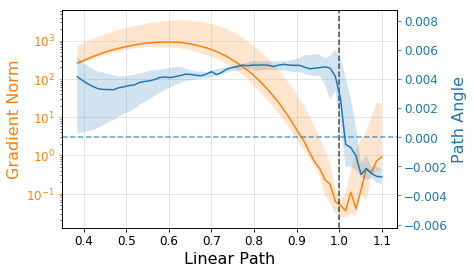

In [17]:
# ONLY-DISC EXP
exp_dir = 'MNIST_PLOT_DATA/DISC_ONLY'
fig_name = 'mnist-path-angle-DISC-ONLY'
hist1 = 6000
hist2 = 42000
step = 6000
DELTA = -0.1
alpha, cos_sim_list, grad_norm_list = load_path_angle(exp_dir, hist1, hist2, step)
plot_avg_cosine_similarity(alpha, cos_sim_list, grad_norm_list, fig_name, exp_dir, delta=DELTA)

loaded 19 hist files!


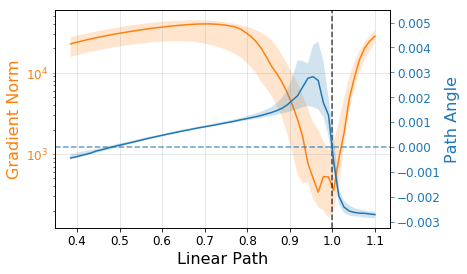

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


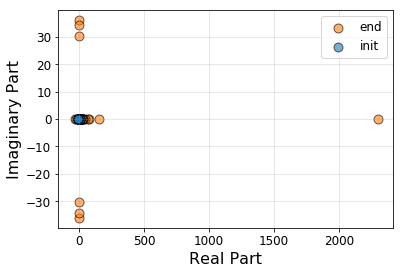

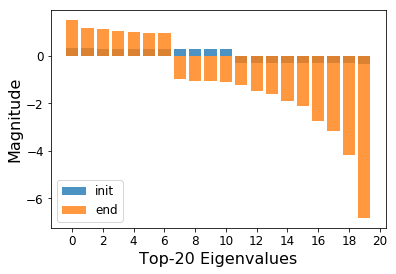

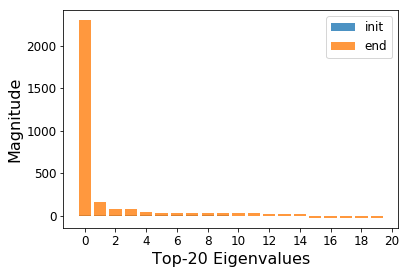

In [18]:
# DCGAN_ADAM EXP
exp_dir = 'MNIST_PLOT_DATA/DCGAN_ADAM'
fig_name = 'mnist-path-angle-NSGAN-ADAM'
hist1 = 63600
hist2 = 117600
step = 3000
DELTA = -.05
alpha, cos_sim_list, grad_norm_list = load_path_angle(exp_dir, hist1, hist2, step)
plot_avg_cosine_similarity(alpha, cos_sim_list, grad_norm_list, fig_name, exp_dir, delta=DELTA)


fig_name = 'mnist-eigenvalues-NSGAN-ADAM'
eigs1 = 0
eigs2 = 114600
dict_eigs1, dict_eigs2 = load_eigen_values(exp_dir, eigs1, eigs2)
plot_eigenvalues(dict_eigs1, dict_eigs2, ['init', 'end'], exp_dir, fig_name)

loaded 23 hist files!


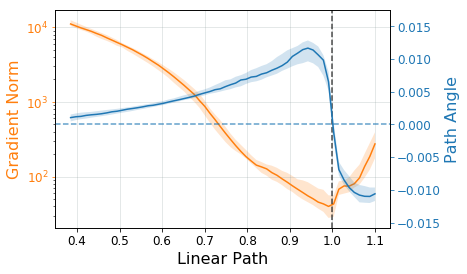

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


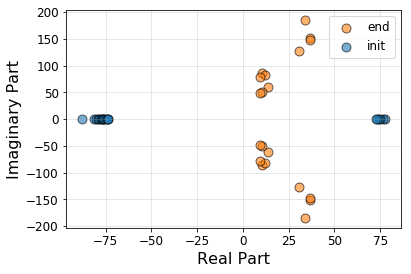

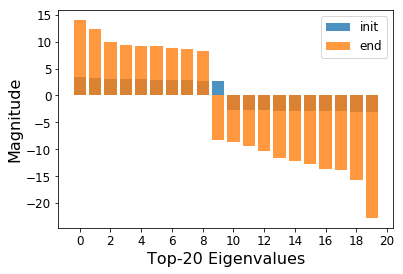

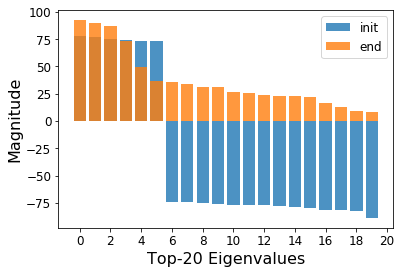

In [19]:
# WGAN-GP_ADAM EXP
exp_dir = 'MNIST_PLOT_DATA/WGAN-GP_ADAM'
fig_name = 'mnist-path-angle-WGAN-GP-ADAM'
hist1 = 171600
hist2 = 237600
step = 3000
DELTA = 0.1
alpha, cos_sim_list, grad_norm_list = load_path_angle(exp_dir, hist1, hist2, step)
plot_avg_cosine_similarity(alpha, cos_sim_list, grad_norm_list, fig_name, exp_dir, delta=DELTA)

fig_name = 'mnist-eigenvalues-WGAN-GP-ADAM'
eigs1 = 0
eigs2 = 237600
dict_eigs1, dict_eigs2 = load_eigen_values(exp_dir, eigs1, eigs2)
plot_eigenvalues(dict_eigs1, dict_eigs2, ['init', 'end'], exp_dir, fig_name)

loaded 19 hist files!


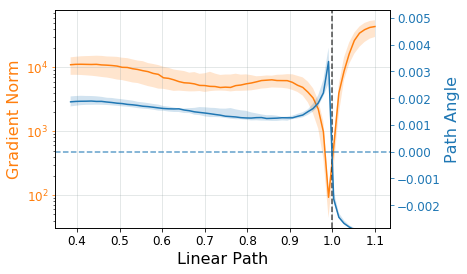

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


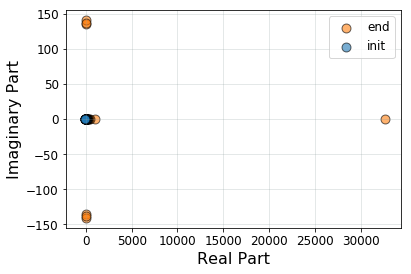

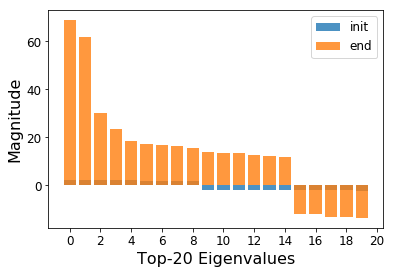

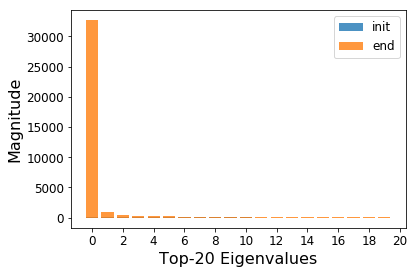

In [20]:
# DCGAN_EXTRA EXP
exp_dir = 'MNIST_PLOT_DATA/DCGAN_EXTRA'
fig_name = 'mnist-path-angle-NSGAN-EXTRA'
hist1 = 63600
hist2 = 117600
step = 3000
DELTA = -.05
alpha, cos_sim_list, grad_norm_list = load_path_angle(exp_dir, hist1, hist2, step)
plot_avg_cosine_similarity(alpha, cos_sim_list, grad_norm_list, fig_name, exp_dir, delta=DELTA)

fig_name = 'mnist-eigenvalues-NSGAN-EXTRA'
eigs1 = 0
eigs2 = 114600
dict_eigs1, dict_eigs2 = load_eigen_values(exp_dir, eigs1, eigs2)
plot_eigenvalues(dict_eigs1, dict_eigs2, ['init', 'end'], exp_dir, fig_name)

loaded 22 hist files!


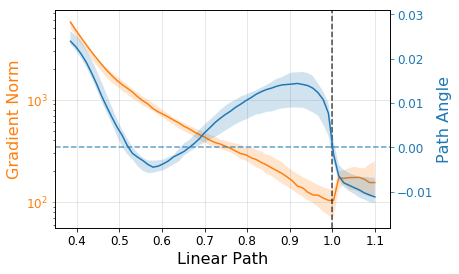

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


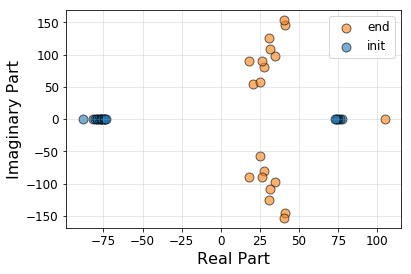

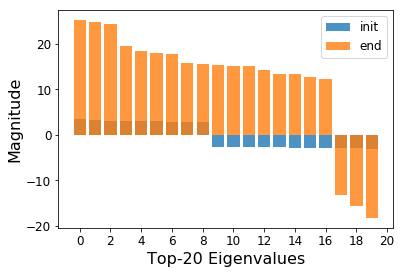

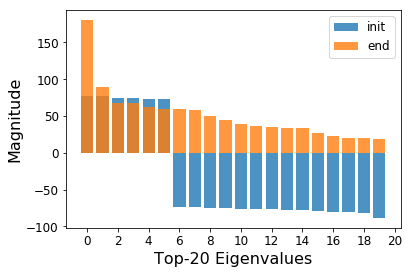

In [21]:
# WGAN-GP_EXTRA EXP
exp_dir = 'MNIST_PLOT_DATA/WGAN-GP_EXTRA'
fig_name = 'mnist-path-angle-WGAN-GP-EXTRA'
hist1 = 171600
hist2 = 234600
step = 3000
DELTA = 0.1
alpha, cos_sim_list, grad_norm_list = load_path_angle(exp_dir, hist1, hist2, step)
plot_avg_cosine_similarity(alpha, cos_sim_list, grad_norm_list, fig_name, exp_dir, delta=DELTA)

fig_name = 'mnist-eigenvalues-WGAN-GP-EXTRA'
eigs1 = 0
eigs2 = 234600
dict_eigs1, dict_eigs2 = load_eigen_values(exp_dir, eigs1, eigs2)
plot_eigenvalues(dict_eigs1, dict_eigs2, ['init', 'end'], exp_dir, fig_name)